## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1) В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2) Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3) Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from tqdm.auto import tqdm

plt.style.use('ggplot')

## Задание 1

**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

**Описание данных**

Файл *problem1-reg_data.csv* - данные о регистрации пользователей

**uid** - уникальный идентификатор пользователя

**reg_ts** - время регистрации пользователя (в формате TimeStamp)

Файл *problem1-auth_data.csv* - данные о регистрации пользователей

**uid** - уникальный идентификатор пользователя

**auth_ts** - время входа пользователя - уже зарегистрированных (в формате TimeStamp)

В качестве retention будем рассчитывать средневзвешенный N-day retention, чтобы учесть различное количество пользователей в когортах

In [2]:
# Функция расчета средневзвешенного N-day Retention
# Функция принимает как полные исходные датасеты, так и семплы
# В подаваемых датафреймах не должно быть пропусков


def n_day_retention_weighted(reg_df,
                             # Датафрейм с информацией по регистрации пользователей(столбцы: reg_ts(int), uid(int))
                             auth_df,
                             # Датафрейм с информацией по авторизации пользователей(столбцы: auth_ts(int), uid(int))
                             n_day  # День, за который необходимо посчитать Retention. Формат - str!!!
                             ):
    # В датафрейме регистраций создаем столбец со временем в формате dt и столбец с принадлежностью uid к когорте
    reg_df['reg_dt'] = pd.to_datetime(reg_df.reg_ts, unit='s').dt.date
    reg_df['cohort'] = pd.to_datetime(reg_df.reg_ts, unit='s').dt.date

    # В датафрейме авторизации создаем столбец с временем в формате datetime
    auth_df['auth_dt'] = pd.to_datetime(auth_df.auth_ts, unit='s').dt.date

    # Проставим в датафрейме авторизаций когорты, к которым относятся авторизации
    # Авторизации, у которых отсутствуют даты регистрации будут отброшены (актуально при использовании семплов)
    df_merged = auth_df.merge(reg_df, how='inner', on='uid')

    # Оставим только уникальные авторизации пользователей за каждый день, 
    # т.к. повторный заход в игру  за день будет приводить к некорректному расчету retention
    df_merged_clr = df_merged.drop_duplicates(subset=['uid', 'auth_dt'])

    # Создадим столбец с разницей между датой регистрации и авторизации (также переведем в формат str)
    df_merged_clr['date_diff'] = (pd.to_datetime(df_merged_clr.auth_dt) - pd.to_datetime(df_merged_clr.reg_dt)) \
        .dt.days.astype('str')

    # Произведем группировку по когорте и date_diff, с подсчетом пользователей внутри каждой группы
    df_merged_grouped = df_merged_clr.groupby(['cohort', 'date_diff'], as_index=False) \
        .agg({'uid': 'count'}) \
        .rename(columns={'uid': 'uid_count'})

    # Переведем сгруппированную таблицу в формат сводной таблицы. Также сбросим индекс получившейся таблицы
    ret_pivot = df_merged_grouped.pivot(index='cohort', columns='date_diff', values='uid_count') \
        .fillna(0) \
        .reset_index()
    ret_pivot.columns.name = None

    # Реализуем расчет средневзвешенного N-day Retention из сводной таблицы
    n_day_ret_w = ((ret_pivot[n_day] / ret_pivot['0'] * 100 * ret_pivot['0']).sum() / ret_pivot['0'].sum()).round(2)

    return n_day_ret_w

In [3]:
# Загрузка данных из папки shared 

reg_df = pd.read_csv('/home/jupyter-k.repin-15/shared/problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('/home/jupyter-k.repin-15/shared/problem1-auth_data.csv', sep=';')

Проведем тестирование функции на семплах (предварительно зададим отсечку в формате Timestamp)

In [4]:
# Тест на семплах

point_ts = 1596229200  # В качестве отсечки возьмем дату 01.08.2020 00:00:00

reg_df_sample = reg_df.loc[reg_df['reg_ts'] >= point_ts, reg_df.columns]
auth_df_sample = auth_df.loc[auth_df['auth_ts'] >= point_ts, auth_df.columns]

In [5]:
# Посчитаем средневзвешенный Retention для 3-го дня на семплах

n_day = '3'

sample_retention = n_day_retention_weighted(reg_df_sample, auth_df_sample, n_day)
sample_retention

4.31

Как результат, получили средневзвешенный 3-day Retention для пользователей, зарегистрированных после временной отсечки 01.08.2020 00:00:00

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Загрузка данных

In [6]:
# Загрузка данных с яндекс-диска по ссылке

download_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A'

df = pd.read_csv(download_url, sep=';')

In [7]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [8]:
# Проверка уникальности пользователей в датафрейме

df.user_id.count() == df.shape[0]

True

Все пользователи в датафрейме уникальны, повторных покупок совершено не было. Проверим утверждение про разницу ARPU в двух группах.

In [9]:
df.groupby('testgroup', as_index=False) \
  .agg({'user_id': 'count', 'revenue': 'mean'}) \
  .rename(columns={'user_id': 'user_count', 'revenue': 'ARPU'})

,testgroup,user_count,ARPU
0,a,202103,25.413720
1,b,202667,26.751287


В самом деле, разница между ARPU в группах 'a' и 'b' составляет 5%.

Приступим к определению лучшего набора предложений. Для начала посмотрим на характер распределения показателя Revenue в группах.

In [10]:
# Предварительно разделим наш датафрейм на два в соответствии с тестовыми группами
a_df = df.query('testgroup == "a"')
b_df = df.query('testgroup == "b"')

# Проверим размеры выборок
a_df.shape, b_df.shape

((202103, 3), (202667, 3))

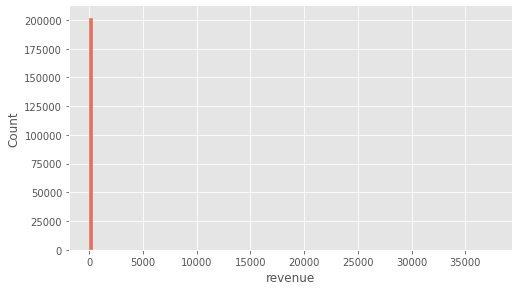

In [11]:
# Распределение "revenue" в группе a
x_a = sns.displot(x='revenue', data=a_df, bins=100)
x_a.fig.set_size_inches(8, 4)

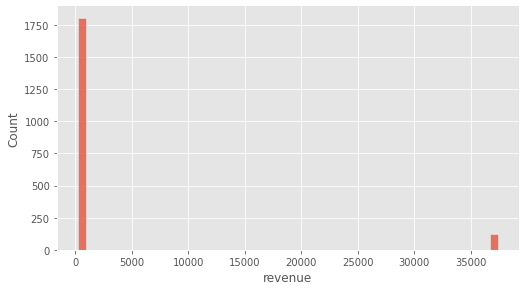

In [12]:
# Распределение "revenue" в группе 'a' по платящим пользователям
x_a = sns.displot(x='revenue', data=a_df.query('revenue != 0'), bins=50)
x_a.fig.set_size_inches(8, 4)

Как видим распределение признака revenue в группе "а" сильно неравномерно. Если взять только ненулевые значения, ты мы увидим, что значения разделяются на две группы: множество малых значений, а также сильно большие значения.

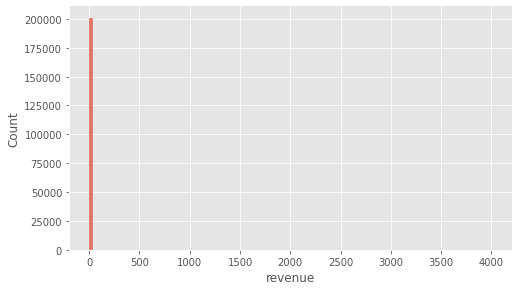

In [13]:
# Распределение "revenue" в группе 'b'
x_b = sns.displot(x='revenue', data=b_df, bins=100)
x_b.fig.set_size_inches(8, 4)

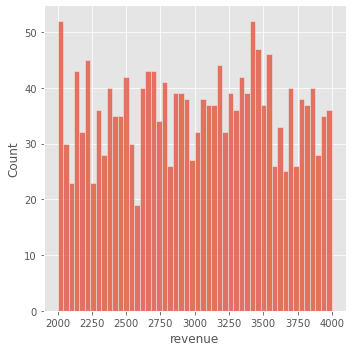

In [14]:
# Распределение "revenue" в группе 'b' по платящим пользователям
x_b = sns.displot(x='revenue', data=b_df.query('revenue != 0'), bins=50)

В группе "b" напротив, все ненулевые значения сосредоточены в одном интервале 2000 - 4000

#### Проверка стат. значимости различий среднего и медины значений revenue двух групп (среди платящих пользователей)

In [15]:
# Оставим в группах только платящих пользователей
a_df_pu = df.query('testgroup == "a" & revenue != 0')
b_df_pu = df.query('testgroup == "b" & revenue != 0')

Так как значения revenue в группе "а" сильно разбросаны, помимо проверки стат. значимых различий среднего значения в группах "a" и "b" имеет смысл также проверить стат. значимость различий медиан.

Т.к выборки в обеих группах имеют распределения далекие от нормального, оптимальным методом проверки стат. значимости различий среднего и медианы будет Bootstrap.

In [16]:
# Объявим функцию, которая позволит проверять гипотезы с помощью Bootstrap


def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок, по умолчанию 1000
        statistic=np.mean,  # интересующая нас статистика, по умолчанию np.mean
        bootstrap_conf_level=0.95  # уровень значимости, по умолчанию 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

#### а) Применяем bootstrap со статистикой np.mean

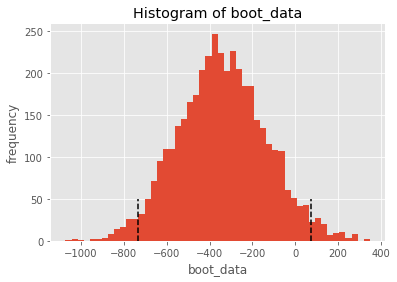

In [17]:
# результат записываем в словарь: вектор разницы двух распределений, доверительный интервал и p-value

booted_data_dict = get_bootstrap(a_df_pu.revenue,  # revenue из группы "a"
                                 b_df_pu.revenue,  # revenue из группы "b"
                                 boot_it=4000,  # количество бутстрэп подвыборок
                                 statistic=np.mean,  # в данном варианте считаем статистику np.mean
                                 bootstrap_conf_level=0.95  # уровень значимости
                                 )

In [18]:
# Доверительный интервал для разницы средних значений двух выборок
booted_data_dict['ci']

,0
0.025,-731.905031
0.975,71.527036


In [19]:
# p-value
booted_data_dict["p_value"]

0.09654567394266392

**Вывод**: т.к. 0 входит в доверительный интервал для разницы средних значений двух выборок, а также p-value больше 0.05, то различие средних значений двух выборок является **статистически незначимым**

#### b) Применяем bootstrap со статистикой np.median

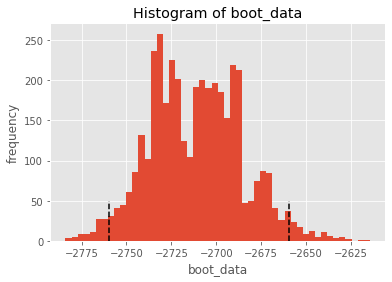

In [20]:
# результат записываем в словарь: вектор разницы двух распределений, доверительный интервал и p-value

booted_data_dict_2 = get_bootstrap(a_df_pu.revenue,  # revenue из группы "a"
                                   b_df_pu.revenue,  # revenue из группы "b"
                                   boot_it=4000,  # количество бутстрэп подвыборок
                                   statistic=np.median,  # в данном варианте считаем статистику np.median
                                   bootstrap_conf_level=0.95  # уровень значимости 
                                   )

In [21]:
# Доверительный интервал для разницы медиан двух выборок
booted_data_dict_2['ci']

,0
0.025,-2759.5000
0.975,-2659.4875


In [22]:
# p-value
booted_data_dict_2["p_value"]

0.0

**Вывод**: т.к. 0 не входит в доверительный интервал для разницы медиан двух выборок, а также p-value меньше 0.05, то различие медиан двух выборок является **статистически значимым**.

В самом деле, значительная разница в медианах у двух групп видна даже без проверки стат. методами:

In [23]:
a_df_pu.revenue.median(), b_df_pu.revenue.median()

(311.0, 3022.0)

#### Вывод:

Средние значения revenue двух групп статистически не различаются, тогда как медианы различаются значительно. При сравнении медиан двух групп явное преимущество у набора предложений группы "b".

#### Проверка значимости различий конверсии (CR) в покупку в группах:

Также по имеющимся данным можно выяснить значимо ли различаются конверсии в покупку в двух группах.

In [24]:
# Посмотрим на значение конверсии в группах
df.groupby('testgroup', as_index=False) \
  .agg({'revenue': lambda x: x[x != 0].count() / x.count()}) \
  .rename(columns={'revenue': 'CR'})

,testgroup,CR
0,a,0.009540
1,b,0.008906


Как видим, конверсии различаются на 7%. Проверим, являются ли данные различия стат. значимыми

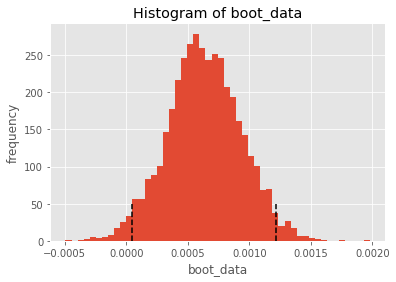

In [25]:
# Применяем Bootstrap к данным

booted_data_dict_3 = get_bootstrap(a_df.revenue,  # revenue из группы "a"
                                   b_df.revenue,  # revenue из группы "b"
                                   boot_it=4000,  # количество бутстрэп подвыборок
                                   statistic=lambda x: np.count_nonzero(x) / len(x),  # Считаем метрику CR
                                   bootstrap_conf_level=0.95  # уровень значимости 
                                   )

In [26]:
# Доверительный интервал для разницы конверсий двух выборок
booted_data_dict_3['ci']

,0
0.025,0.000049
0.975,0.001219


In [27]:
# p-value
booted_data_dict_3["p_value"]

0.03297144940343318

#### Вывод

В результате проведенного теста оказалось, что конверсия в группах стат. значимо различается: в группе "а" конверсия выше чем в "b".

### Общий вывод по задаче:

В результате проведенных тестов выяснилось, что медианное значение revenue в группе "b" стат. значимо больше чем в группе "а" (причем значительно). В то же время конверсия в покупку оказалась стат. значимо выше в группе "а", чем в "b".

В качестве итогового решения я бы принял набор предложений "b", т.к. на мой взгляд значительная разница в медианах между группами существеннее разницы в конверсии между группами (хоть и стат. значимой). 

Также в данном задании мы не можем проверить источник данных. Вполне вероятно, что слишком высокие значения revenue в группе "а" обусловлены ошибками при сборе данных.

**Ответ**: набор предложений "b" является лучшим.

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Сначала я бы обратил внимание на метрики трафика:**

1) **avg. DAU** - средняя дневная аудитория ивента. Смотрим на среднее количество уникальных игроков в день, участвующих в ивенте. В качестве периода, за который берется среднее значение, необходимо взять продолжительность ивента.

2) **EAU (Event Active Users**) - общая аудитория ивента на всем его протяжении.

3) **Stickness ratio** = avg. DAU / EAU. Метрика "прилипания" к ивенту. Смотрим насколько часто пользователи участвуют в ивенте во время его проведения.

**Также важно отслеживать метрики конверсии (CR):**

Можно предложить следующую цепочку конверсии: **регистрация в ивенте ---> участие в ивенте ---> прохождение уровня ---> получение награды**

Конверсию необходимо отслеживать как на каждом шаге (чтобы видеть локальные провалы и работать с ними), так и абсолютно.

Также можно смотреть конверсию внутри корзины **"получение награды"**, 
например **"игроки заработавшие 1 приз" --> "игроки заработавшие 5 призов" --> "игроки заработавшие 10 призов"** и т.д., чтобы видеть насколько далеко заходят игроки и на каком этапе они отваливаются (возможно на какой либо ступени слишком высокая сложность, какие-либо баги, либо призы уже не такие интересные и нет стимула двигаться дальше и т.д.)

Также важно отслеживать **Конверсионное окно (Conversion Window)** - среднюю продолжительность цикла целевого действия, чтобы видеть насколько быстро пользователи переходят от одного участка воронки к другому.

**Также важно отслеживать показатель Retention**

Пользователи делятся по когортам в зависимости от даты регистрации в ивенте и затем расчитывается **N-day Retention** для каждой когорты. Чтобы оценить общее удержание игроков в ивенте будем расчитывать **средневзвешенный N-day Retention**, чтобы учитывать различные размеры когорт пользователей.

**Rolling-Retention** отслеживать не стоит, т.к ивенты непродолжительные (раз в месяц) и Rolling-Retention способен несколько исказить картину удержания игроков в данном случае. 

**Прочие метрики**

**PSAT (player satisfaction score)** - с помощью этой метрики оценим общий уровень недовольства игроков ивентом. Выборочно будем проводить опросы с просьбой оценить ивент по шкале 1-10. Далее рассчитаем **PSAT** путем деления общего количества баллов на количество опрошенных игроков.

$$ PSAT = \cfrac{сумма\ баллов\ опрошенных\ игроков}{количество\ опрошенных\ игроков} * 100\% $$

**Фактор виральности**:

   **Внутриигровой** - привлекаем игроков из этой же игры поучаствовать в ивенте \
   **Внеигровой** - приглашаем новых игроков, которые не были зарегистрированы в игре до этого

$$ К−фактор = X * Y * Z $$

    X - процент игроков, которые пригласили новых игроков в ивент \
    Y - среднее число игроков, которое пригласил один игрок \
    Z - число игроков, которые приняли приглашение

Данный коэффициент покажет нам насколько наш ивент нравится игрокам и насколько быстро распространяется информация о нем.

**ASL (average session length)** - средняя продолжительность сессии игроков в ивенте. Смотрим какова средняя длинна сессии игроков в ивенте.

**Кастомные метрики:** 

**Среднее количество пройденных уровней:**
    $$ Среднее\ количество\ пройденных\ уровней = \cfrac{количество\ уровней,\ пройденных\ всеми\ игроками}{количество\ игроков\ участвовавших\ в\ ивенте} $$

**Среднее количество полученных наград:**
    $$ Среднее\ количество\ полученных\ наград = \cfrac{количество\ наград,\ полученных\ всеми\ игроками}{количество\ игроков\ участвовавших\ в\ ивенте} $$

Данные кастомные метрики показывают уровень вовлеченности игроков в ивент.

#### Введение механики "отката" уровней

Введение механики "отката" увеличит сложность получения наград и может привести как к повышению интереса игроков к ивенту, так и усилить отток (при значительном увеличении сложности). Поэтому очень важно найти баланс между повышением интереса к игре и оттоком игроков.

Увеличение интереса к ивенту мы сможем отследить через метрики введенные выше (например ASL)

Для контроля оттока введем следующие метрики:

**Количество откатов** - сколько раз конкретный игрок откатился за время ивента

**Churn** - так как в данном случае появляется сильный триггер оттока игроков в виде отката уровней (некоторые захотят уйти из ивента после n-откатов). На основе предыдущей метрики (**Количество откатов**) мы можем прогнозировать отток и сделать его оптимальным.

Также дополнительно я бы проводил выборочные опросы среди игроков "Довольны ли вы введением новой механики в игру?" и рассчитывал бы показатель удовлетворенности по формуле:

$$ Удовлетворенность\ механикой = \cfrac{количество\ ответов\ "да"}{количество\ опрошенных\ игроков} * 100\% $$